# CS 4641 GROUP 30
### Predicting the Results of NBA Games

Dataset: [NBA Games](https://www.kaggle.com/code/nathanlauga/nba-games-eda-let-s-dive-into-the-data)

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from pca import PCA

pd.set_option('display.max_columns', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-23 14:47:38.649098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
teams = pd.read_csv("raw_data/teams.csv")
players = pd.read_csv("raw_data/players.csv")
games = pd.read_csv("raw_data/games.csv")
rankings = pd.read_csv("raw_data/ranking.csv")
games_details = pd.read_csv("raw_data/games_details.csv")

In [3]:
display(games.head())

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-02-03,21900741,Final,1610612766,1610612753,2019,1610612766,100.0,0.461,0.643,0.290,24.0,46.0,1610612753,112.0,0.538,0.588,0.471,35.0,37.0,0
1,2020-02-03,21900742,Final,1610612739,1610612752,2019,1610612739,134.0,0.565,0.667,0.514,34.0,34.0,1610612752,139.0,0.559,0.714,0.385,33.0,46.0,0
2,2020-02-03,21900743,Final,1610612754,1610612742,2019,1610612754,103.0,0.458,0.727,0.206,28.0,40.0,1610612742,112.0,0.419,0.957,0.400,20.0,51.0,0
3,2020-02-03,21900744,Final,1610612764,1610612744,2019,1610612764,117.0,0.506,0.828,0.409,28.0,35.0,1610612744,125.0,0.494,0.774,0.500,31.0,44.0,0
4,2020-02-03,21900745,Final,1610612737,1610612738,2019,1610612737,115.0,0.500,0.905,0.400,22.0,32.0,1610612738,123.0,0.533,0.882,0.414,21.0,44.0,0


<center>

|Column|Description|
|:----:|:-------:|
|<code>GAME_DATE_EST</code>|Date the game took place|
|<code>GAME_ID</code>|Unique numerical identifier for the game|
|<code>GAME_STATUS_TEXT</code>|Describes whether the game was a final or not|
|<code>HOME_TEAM_ID</code>|Unique numerical identifier for the home team|
|<code>VISITOR_TEAM_ID</code>|Unique numerical identifier for the away team|
|<code>SEASON</code>|NBA Season in which the game took place|
|<code>TEAM_ID_home</code>|Unique numerical identifier for the home team (redundant)|
|<code>PTS_home</code>|Points scored by the home team|
|<code>FG_PCT_home</code>|Percentage of 2 point field goals made by the home team|
|<code>FT_PCT_home</code>|Percentage of free throws made by the home team|
|<code>FG3_PCT_home</code>|Percentage of 3 point field goals made by the home team|
|<code>AST_home</code>|Number of assists made by the home team|
|<code>REB_home</code>|Number of rebounds made by the home team|
|<code>TEAM_ID_away</code>|Unique numerical identifier for the away team (redundant)|
|<code>PTS_away</code>|Points scored by the away team|
|<code>FG_PCT_away</code>|Percentage of 2 point field goals made by the away team|
|<code>FT_PCT_away</code>|Percentage of free throws made by the away team|
|<code>FG3_PCT_away</code>|Percentage of 3 point field goals made by the away team|
|<code>AST_away</code>|Number of assists made by the away team|
|<code>REB_away</code>|Number of rebounds made by the away team|
|<code>HOME_TEAM_WINS</code>|1 if the home team won the game, 0 if they lost|
<center>

# Preprocessing

In [4]:
teamDict = dict(zip(teams["TEAM_ID"], teams["ABBREVIATION"]))                    # Map unique team ids to team abbreviations
modified_games = games.replace(teamDict)                                         # Get rid of team IDs, just use team abbreviations (can undo if bad)
modified_games = modified_games.drop(columns=["TEAM_ID_home", "TEAM_ID_away"])   # redundant columns
modified_games = modified_games.drop(columns=["GAME_STATUS_TEXT"])               # Every value in column is 'final' -> not useful

modified_games.dropna(inplace=True)                                              # Get rid of rows with blank or N/A values

y = modified_games["HOME_TEAM_WINS"]
y = y.to_numpy()

to_pca = modified_games.select_dtypes((int, float))
to_pca = to_pca.drop(columns=["GAME_ID", "SEASON", "HOME_TEAM_WINS"])   # Get rid of labels, just keep numerical data
to_pca = to_pca.drop(columns=["PTS_home", "PTS_away"])                  # Points per game is just HOME_TEAM_WINS
display(to_pca.head())
print(to_pca.shape)
print(to_pca)

current_directory = os.getcwd()
df = pd.DataFrame(to_pca)
excel_file_path = os.path.join(current_directory, 'Preprocessings.xlsx')
df.to_excel(excel_file_path, index=False)

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,0.461,0.643,0.290,24.0,46.0,0.538,0.588,0.471,35.0,37.0
1,0.565,0.667,0.514,34.0,34.0,0.559,0.714,0.385,33.0,46.0
2,0.458,0.727,0.206,28.0,40.0,0.419,0.957,0.400,20.0,51.0
3,0.506,0.828,0.409,28.0,35.0,0.494,0.774,0.500,31.0,44.0
4,0.500,0.905,0.400,22.0,32.0,0.533,0.882,0.414,21.0,44.0


(22945, 10)
       FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
0            0.461        0.643         0.290      24.0      46.0   
1            0.565        0.667         0.514      34.0      34.0   
2            0.458        0.727         0.206      28.0      40.0   
3            0.506        0.828         0.409      28.0      35.0   
4            0.500        0.905         0.400      22.0      32.0   
...            ...          ...           ...       ...       ...   
23039        0.419        0.821         0.421      24.0      50.0   
23040        0.338        0.719         0.381      18.0      40.0   
23041        0.448        0.682         0.500      29.0      45.0   
23042        0.440        0.771         0.333      21.0      30.0   
23043        0.431        0.679         0.333      18.0      42.0   

       FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
0            0.538        0.588         0.471      35.0      37.0  
1            0.559     

### PCA

In [5]:
pca = PCA()

to_pca = to_pca.to_numpy()

pca.fit(to_pca)
features = pca.transform_rv(to_pca, 0.95)      # 0.95 is completely arbitrary, should talk to mentor re: good value for this
print(f"Shape after PCA: {features.shape}")
# print(features)
print(features)
current_directory = os.getcwd()
df = pd.DataFrame(features)
excel_file_path = os.path.join(current_directory, 'PCAAdjustment.xlsx')
df.to_excel(excel_file_path, index=False)

Shape after PCA: (22945, 4)
[[  2.0246366   -3.17500951  10.2975257  -10.36048518]
 [  6.33342145   8.02211397  16.37487942   1.8119419 ]
 [ -2.89997735   7.34147835   3.94708786   6.89732323]
 ...
 [ -1.97493899  -2.05096994   3.48088268   5.58577795]
 [  8.05360959   9.88304197  -3.56835246   4.43447028]
 [  0.38299075   1.45496648  -4.70548137  -1.20757655]]


# Classification
### Logistic Regression

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.8, random_state=16)

clf = LogisticRegression()
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_test)
pred = preds.argmax(axis=1)

accuracy = accuracy_score(y_test, pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7533231640880366


## SVM

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.8, random_state=16)

cls = svm.LinearSVC(max_iter=100000)
cls.fit(X_train, y_train)
preds = cls.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7531052516888211


## CNN

In [8]:
# Create a convolutional neural network model 
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.8, random_state=16)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

model.save('my_model.keras')

Epoch 1/10
574/574 [==============================] - 2s 2ms/step - loss: 0.5219 - accuracy: 0.7324 - val_loss: 0.5045 - val_accuracy: 0.7448
Epoch 2/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5110 - accuracy: 0.7418 - val_loss: 0.5097 - val_accuracy: 0.7426
Epoch 3/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5101 - accuracy: 0.7423 - val_loss: 0.5018 - val_accuracy: 0.7498
Epoch 4/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5084 - accuracy: 0.7437 - val_loss: 0.5062 - val_accuracy: 0.7448
Epoch 5/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5074 - accuracy: 0.7442 - val_loss: 0.5022 - val_accuracy: 0.7505
Epoch 6/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5071 - accuracy: 0.7453 - val_loss: 0.5010 - val_accuracy: 0.7520
Epoch 7/10
574/574 [==============================] - 1s 1ms/step - loss: 0.5065 - accuracy: 0.7453 - val_loss: 0.4979 - val_accuracy: 0.7511
Epoch 

# Visualization
### PCA 1 and 2 Up-close Comparison + PCA 3 and 4 Up-close Comparison

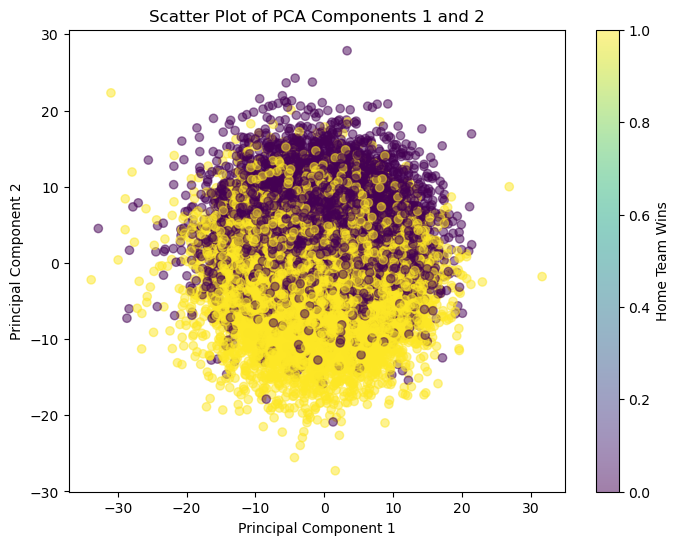

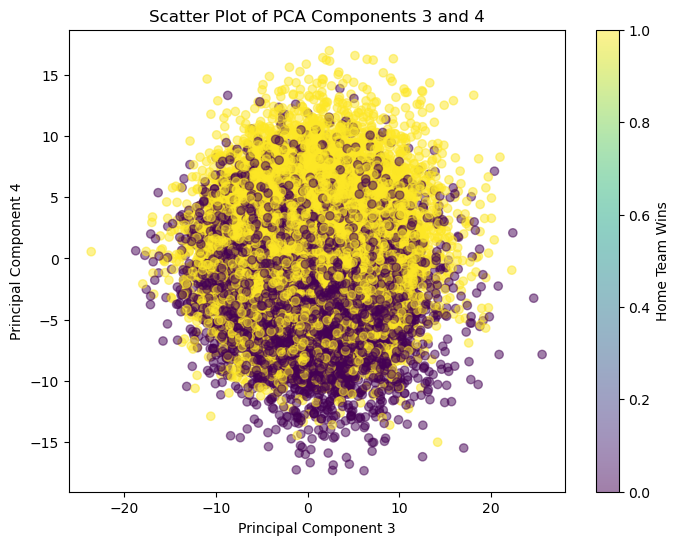

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PCA Components 1 and 2')
plt.colorbar(label='Home Team Wins')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(features[:, 2], features[:, 3], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.title('Scatter Plot of PCA Components 3 and 4')
plt.colorbar(label='Home Team Wins')
plt.show()


### All PCA Comparisons

/Users/jakecranor/anaconda3/envs/ml_hw1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jakecranor/anaconda3/envs/ml_hw1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jakecranor/anaconda3/envs/ml_hw1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jakecranor/anaconda3/envs/ml_hw1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

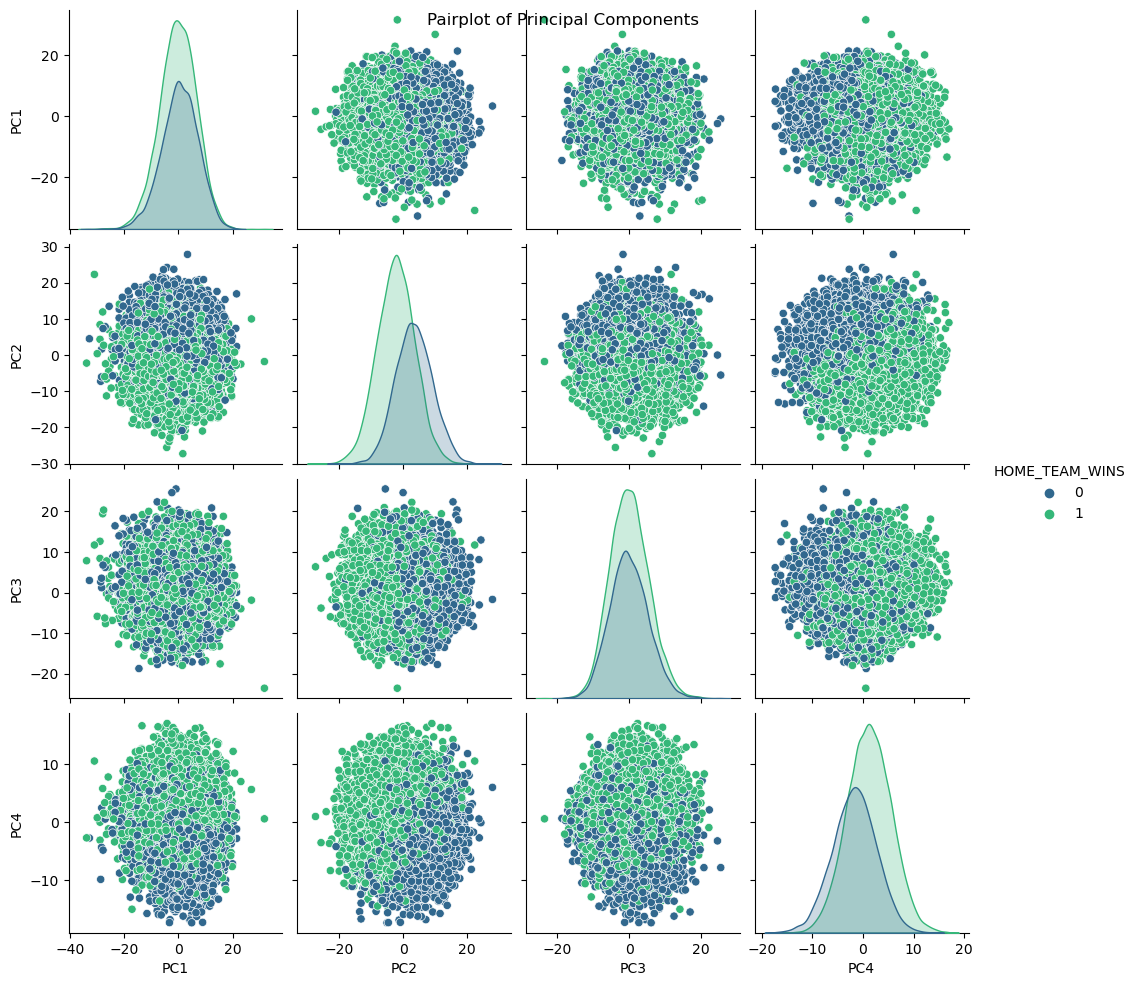

In [10]:
pca_df = pd.DataFrame(features, columns=[f'PC{i+1}' for i in range(features.shape[1])])
pca_df['HOME_TEAM_WINS'] = y

sns.pairplot(pca_df, hue='HOME_TEAM_WINS', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot of Principal Components')
plt.show()

### All Logistic Regression Comparisons

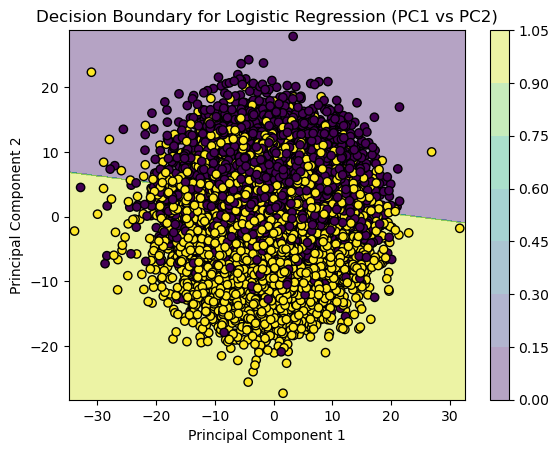

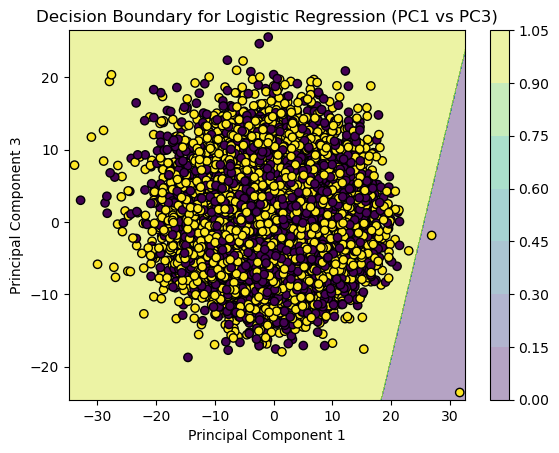

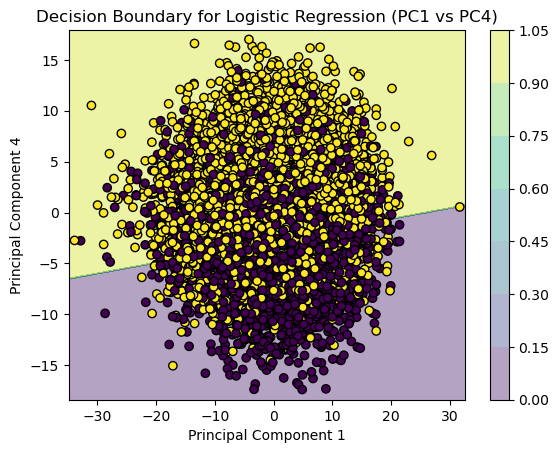

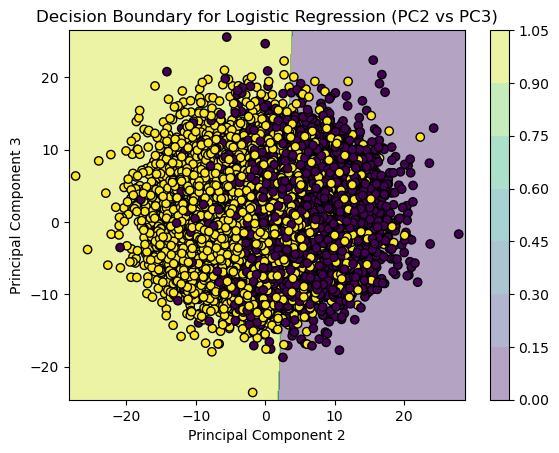

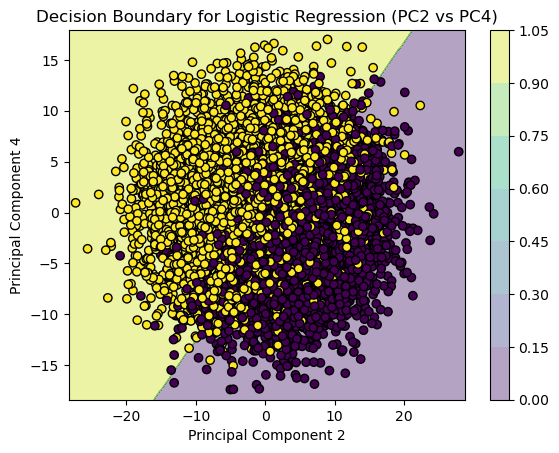

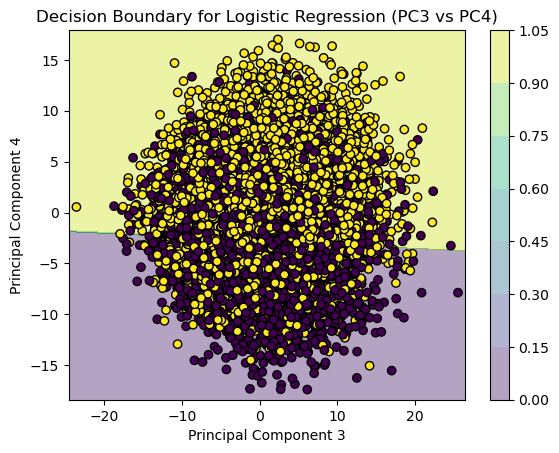

In [11]:
# Fit logistic regression model and plot decision boundary for each combination of principal components
for i in range(4):
    for j in range(i+1, 4):
        log_reg = LogisticRegression()
        log_reg.fit(features[:, [i, j]], y)
        
        x_min, x_max = features[:, i].min() - 1, features[:, i].max() + 1
        y_min, y_max = features[:, j].min() - 1, features[:, j].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))
        Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
        plt.colorbar()
        plt.xlabel(f'Principal Component {i+1}')
        plt.ylabel(f'Principal Component {j+1}')
        plt.scatter(features[:, i], features[:, j], c=y, cmap='viridis', edgecolors='k')
        plt.title(f'Decision Boundary for Logistic Regression (PC{i+1} vs PC{j+1})')
        plt.show()


### SVM Visualizations

Decision Boundary

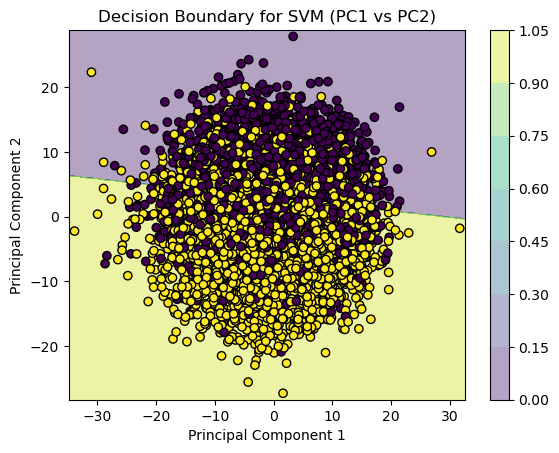

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.8, random_state=16)

i, j = 0, 1  
clf = svm.SVC(kernel='linear')
clf.fit(X_train[:, [i, j]], y_train)

x_min, x_max = X_train[:, i].min() - 1, X_train[:, i].max() + 1
y_min, y_max = X_train[:, j].min() - 1, X_train[:, j].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
plt.colorbar()
plt.xlabel(f'Principal Component {i+1}')
plt.ylabel(f'Principal Component {j+1}')
plt.scatter(X_train[:, i], X_train[:, j], c=y_train, cmap='viridis', edgecolors='k')
plt.title(f'Decision Boundary for SVM (PC{i+1} vs PC{j+1})')
plt.show()


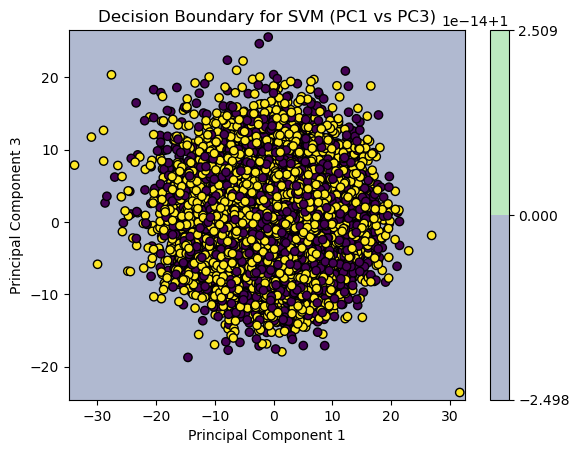

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.8, random_state=16)

i, j = 0, 2  
clf = svm.SVC(kernel='linear')
clf.fit(X_train[:, [i, j]], y_train)

x_min, x_max = X_train[:, i].min() - 1, X_train[:, i].max() + 1
y_min, y_max = X_train[:, j].min() - 1, X_train[:, j].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
plt.colorbar()
plt.xlabel(f'Principal Component {i+1}')
plt.ylabel(f'Principal Component {j+1}')
plt.scatter(X_train[:, i], X_train[:, j], c=y_train, cmap='viridis', edgecolors='k')
plt.title(f'Decision Boundary for SVM (PC{i+1} vs PC{j+1})')
plt.show()

### CNN Visualizations

Model Loss

Epoch 1/10
574/574 [==============================] - 3s 3ms/step - loss: 0.5220 - accuracy: 0.7368 - val_loss: 0.5099 - val_accuracy: 0.7444
Epoch 2/10
574/574 [==============================] - 2s 3ms/step - loss: 0.5119 - accuracy: 0.7404 - val_loss: 0.5015 - val_accuracy: 0.7520
Epoch 3/10
574/574 [==============================] - 1s 3ms/step - loss: 0.5092 - accuracy: 0.7422 - val_loss: 0.4999 - val_accuracy: 0.7520
Epoch 4/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5093 - accuracy: 0.7442 - val_loss: 0.4998 - val_accuracy: 0.7494
Epoch 5/10
574/574 [==============================] - 1s 1ms/step - loss: 0.5084 - accuracy: 0.7424 - val_loss: 0.5036 - val_accuracy: 0.7442
Epoch 6/10
574/574 [==============================] - 1s 1ms/step - loss: 0.5071 - accuracy: 0.7424 - val_loss: 0.5057 - val_accuracy: 0.7394
Epoch 7/10
574/574 [==============================] - 1s 2ms/step - loss: 0.5067 - accuracy: 0.7456 - val_loss: 0.5002 - val_accuracy: 0.7479
Epoch 

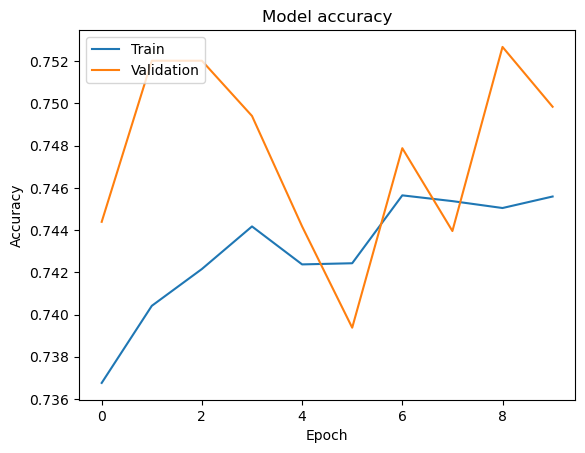

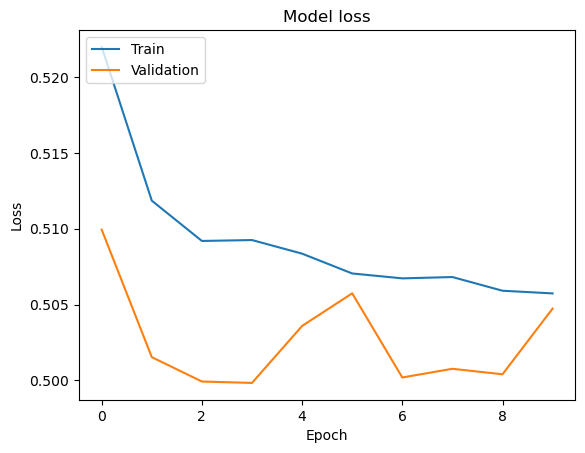

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

model.save('my_model.keras')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Confusion Matrix

Epoch 1/5
1875/1875 [==============================] - 60s 31ms/step - loss: 0.1270 - accuracy: 0.9612
Epoch 2/5
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0431 - accuracy: 0.9870
Epoch 3/5
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0292 - accuracy: 0.9905
Epoch 4/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0211 - accuracy: 0.9930
Epoch 5/5
313/313 [==============================] - 3s 11ms/step


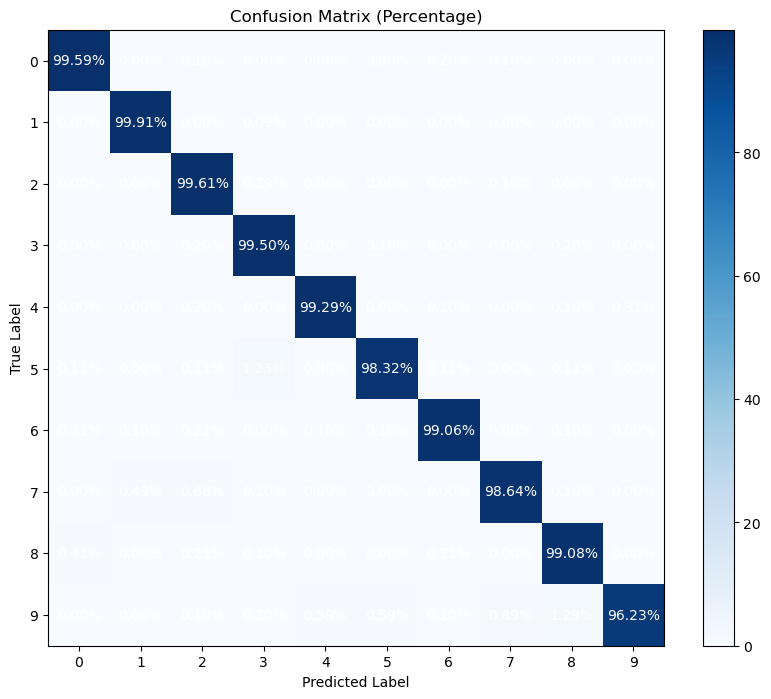

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

features, labels = X_test, y_test

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

y_pred = np.argmax(model.predict(X_test), axis=-1)

conf_matrix = confusion_matrix(y_true=labels, y_pred=y_pred)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_percent, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix (Percentage)')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.grid(False)
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}%', ha='center', va='center', color='white')
plt.show()
